In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from khaiii import KhaiiiApi
from tqdm import tqdm

import collections
import seaborn as sns

In [2]:
#한글 깨짐 처리
import os

if os.name == 'posix':
    plt.rc("font", family="AppleGothic")

else :
    plt.rc("font", family="Malgun Gothic")

%config InlineBackend.figure_format = 'retina'

In [3]:
train = pd.read_csv("capstone_dataset/train.csv")
val = pd.read_csv("capstone_dataset/valid.csv")
test = pd.read_csv("capstone_dataset/test.csv")

In [4]:
print(len(train))
train.head()

100000


,id,title,body,category,label
0,AKR20191006026700004,공소시효 만료로 수배 해제 5년간 2만3천건…하루 13건꼴,공소시효가 만료돼 수배가 해제되는 사건이 하루 12∼13건꼴인 것으로 조사됐다. 6...,3,0
1,AKR20190201116900051,설 연휴 부산 병·의원 2천75곳 문 연다,이번 설 연휴 부산에서는 모두 2천75곳의 병·의원이 문을 연다. 부산시는 2일부터...,3,0
2,AKR20200731075300061,"시흥시, 청년근로자 100명에 60만원씩 복지포인트 지급","경기 시흥시는 관내 시흥청년해피기업에 근무하는 청년 근로자 100명을 선정, 1인당...",7,0
3,AKR20191220114000001,"한국당 5일째 패스트트랙法 규탄대회…""4+1, 文정권에 예산뇌물""",자유한국당 황교안 대표와 민주평화당 정동영·정의당 이정미 대표는 4일 상견례 자리에...,1,1
4,AKR20191029112900057,"울산시의원 ""시민 참여 온라인 쇼핑몰 울산몰 만들자""",경남도의회는 11일 제10호 태풍 하이선으로 낙과 피해를 본 밀양시 산내면 사과 재...,1,1


In [5]:
print(len(val))
print(len(test))

25000
25000


In [6]:
len(train.body[0])

486

# EDA

제목 평균 글자수: 30.17576


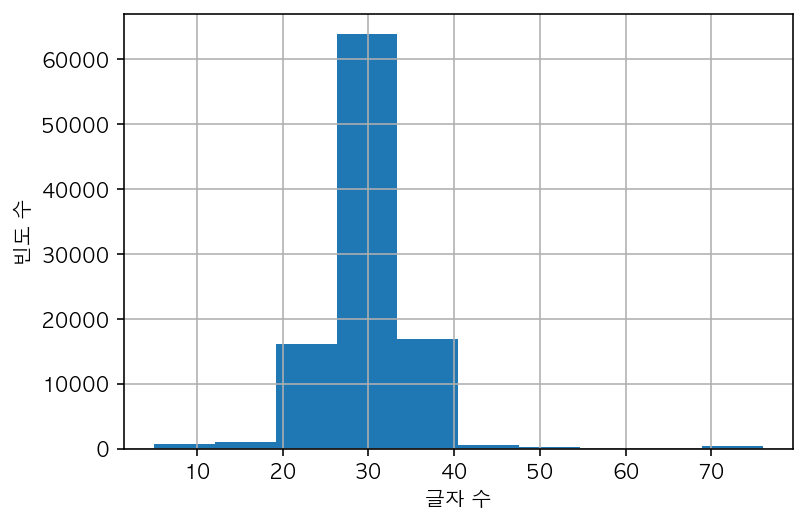

In [7]:
ax = train.title.str.len().hist()
ax.set_xlabel('글자 수')
ax.set_ylabel('빈도 수')

avg = sum([len(title) for title in train.title])/len(train)
print('제목 평균 글자수:',avg)

본문 평균 글자수: 861.01799
본문 최대 글자수: 18797


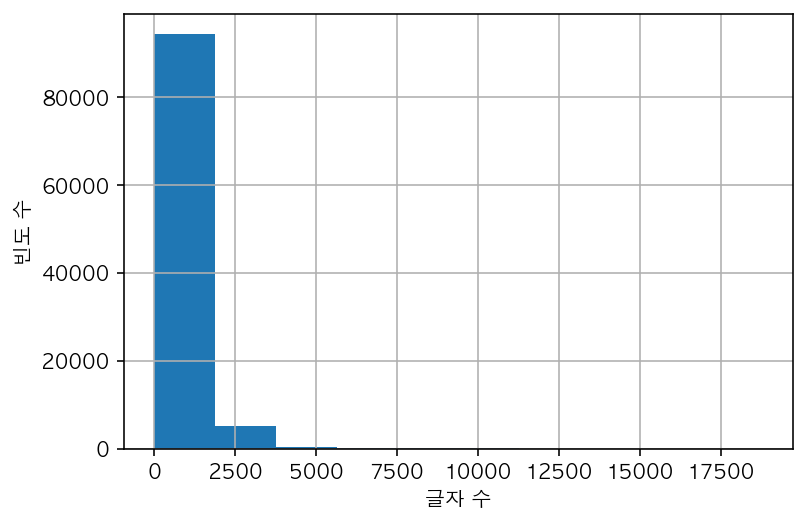

In [8]:
ax1 = train.body.str.len().hist()
ax1.set_xlabel('글자 수')
ax1.set_ylabel('빈도 수')

avg = sum([len(body) for body in train.body])/len(train)
max_body = max([len(body) for body in train.body])
print('본문 평균 글자수:',avg)
print('본문 최대 글자수:',max_body)

(0.0, 3000.0)

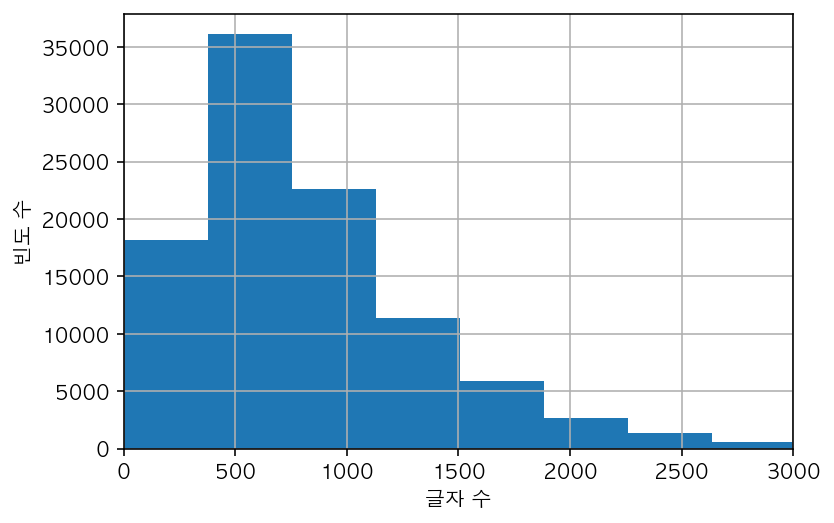

In [9]:
ax2 = train.body.str.len().hist(bins=50)
ax2.set_xlabel('글자 수')
ax2.set_ylabel('빈도 수')
ax2.set_xlim(0,3000)

In [10]:
#토큰 수
token_by_space = list(train.body.str.split().map(lambda x: len(x)))
avg = sum(token_by_space)/len(train)
max_body = max(token_by_space)

print('본문 평균 토큰수:',avg)
print('본문 최대 토큰수:',max_body)

본문 평균 토큰수: 195.20495
본문 최대 토큰수: 3208


(-4.0, 1000.0)

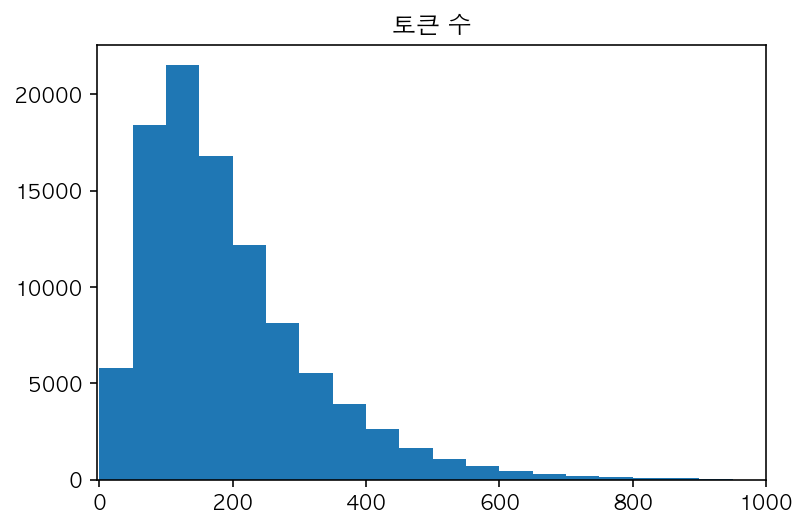

In [11]:
bins = np.arange(0,1000,50) 
plt.hist(np.array(token_by_space),bins=bins)
plt.title("토큰 수")
plt.xlim([min(token_by_space)-5,1000])

100%|██████████| 100000/100000 [02:14<00:00, 744.03it/s]


<AxesSubplot:>

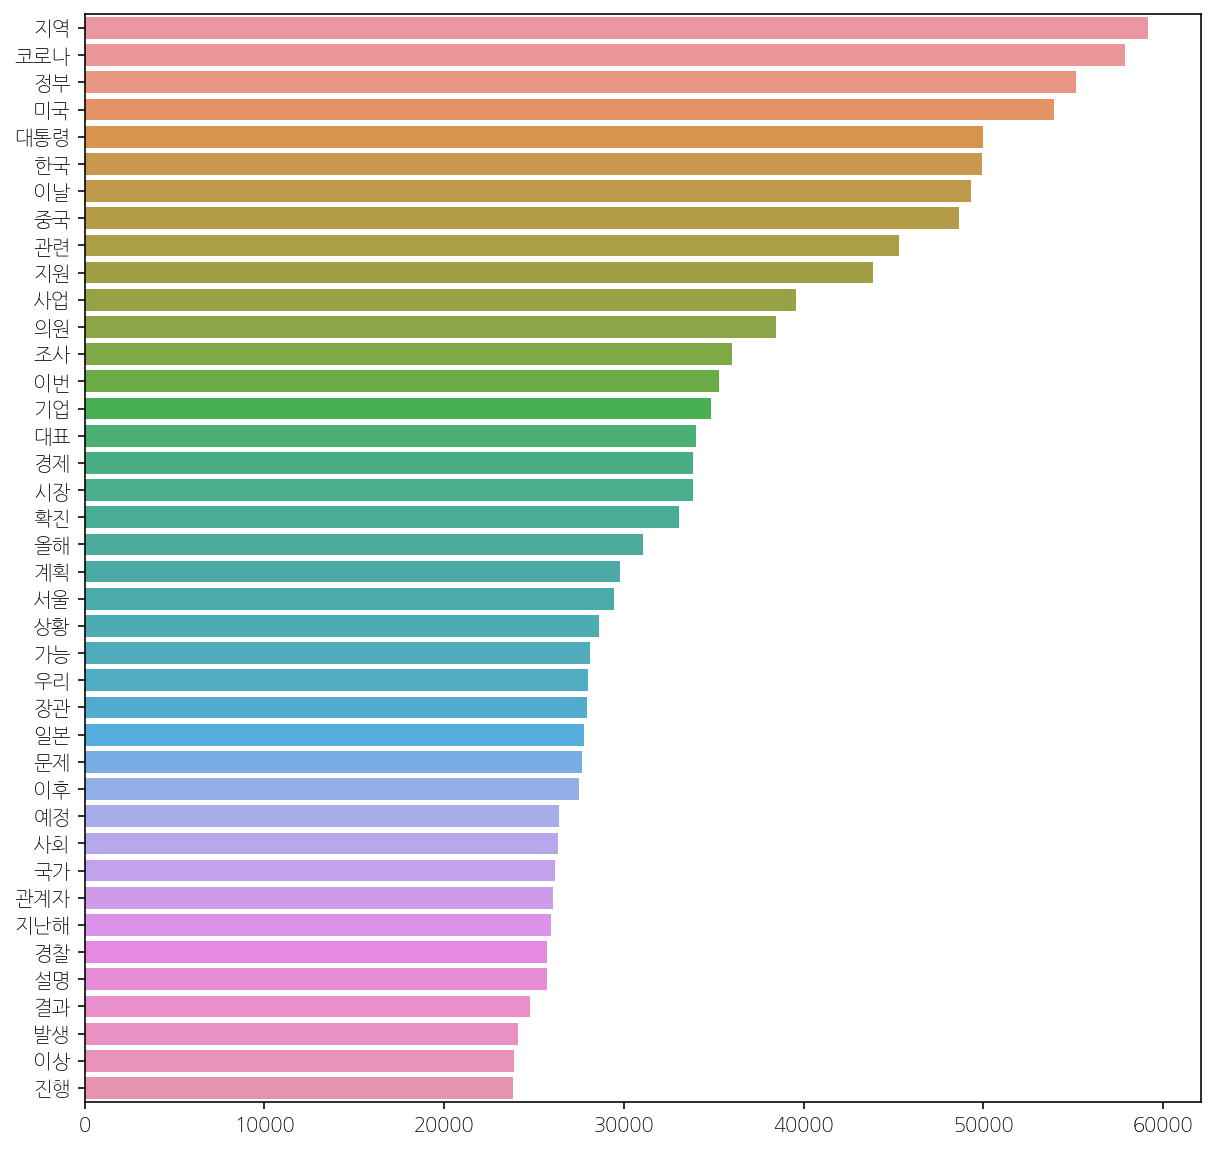

In [12]:
## 명사별 개수
# 명사 추출 > 전체 코퍼스로 구축 > 개수 세기 > 시각화
from konlpy.tag import Mecab
m = Mecab()

body = train.body.to_list()
n_corpus = []
for b in tqdm(body):
    for n in m.nouns(b): #명사 추출
        if len(n) > 1: #2글자 이상의 명사
            n_corpus.append(n)

count = collections.Counter(n_corpus)
most = count.most_common() #빈도 수 순으로 추출

x, y= [], []
for word,count in most[:40]:
    x.append(word)
    y.append(count)

plt.rcParams['font.family'] = 'NanumGothic'
plt.figure(figsize=(10,10))
sns.barplot(x=y,y=x)

100%|██████████| 100000/100000 [02:14<00:00, 744.66it/s]


[Text(0.5, 0, '빈도수'), Text(0, 0.5, '형태소')]

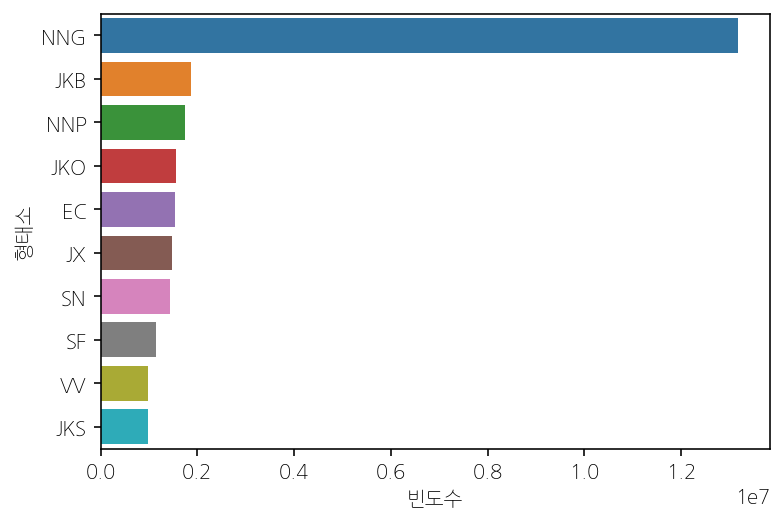

In [13]:
#형태소별 통계
tags = []
for b in tqdm(body):
    temp = m.pos(b)
    for p in temp:
        tags.append(p[1])
counter = collections.Counter(tags)
x,y = list(map(list,zip(*counter.most_common(10))))
ax = sns.barplot(x=y, y=x)
ax.set(xlabel='빈도수',ylabel='형태소')

- 일반명사 > 고유명사 > 관형격조사 > 주격조사 > 부사격조사 > 부호 > 목적격조사 > 관형형 전성 어미 > 보조사 > 구분자

품사 태그 정보
https://docs.google.com/spreadsheets/d/1-9blXKjtjeKZqsf4NzHeYJCrr49-nXeRF6D80udfcwY/edit

# preprocessing

In [ ]:
#1. clean the text
train['body'] = train['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

tokenized_data = []
for sentence in tqdm(train['body']):
    tokenized_sentence = m.morphs(sentence) #2. tokenization
    removed_by_len_sentence = [word for word in tokenized_sentence if len(word)>1 ]
    tokenized_data.append(removed_by_len_sentence)

<ipython-input-14-256146936ea4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train['body'] = train['body'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
 35%|███▌      | 35066/100000 [00:52<01:25, 763.59it/s]

In [ ]:
train['token'] = tokenized_data

In [ ]:
# body 길이 분포 확인
print('body의 최대 길이 :',max(len(review) for review in tokenized_data))
print('body의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlim(0,1000)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
len_token = [len(review) for review in tokenized_data]
len_token = np.array(len_token)
np.percentile(len_token, 95) #value of padding

In [ ]:
#정수인코딩
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(tokenized_data)
vocab_size = len(tokenizer.word_index) + 1 # 패딩을 고려하여 +1
X_encoded = tokenizer.texts_to_sequences(tokenized_data)
X_padded = pad_sequences(X_encoded, maxlen=419)

In [ ]:
vocab_size

# word2vec

In [ ]:
! pip install gensim==3.8.3

In [ ]:
from gensim.models import Word2Vec
#pretrained_model
model = gensim.models.Word2Vec.load('/Users/saeran/Desktop/SJU2022/캡스톤/word2vecKo/ko.bin')
model.wv.save_word2vec_format('ko.bin.gz') #저장하지않으면, 나중에 Intersect시에 codec오류가 있음

In [ ]:
from gensim.models import Word2Vec, KeyedVectors

w2v = Word2Vec(size=200, min_count=1)#news data로 학습
w2v.build_vocab(tokenized_data)
total_examples = w2v.corpus_count

In [ ]:
w2v.build_vocab([list(model.wv.vocab.keys())], update=True)
w2v.intersect_word2vec_format("ko.bin.gz", binary=False)
w2v.train(tokenized_data, total_examples=total_examples, epochs=model_2.iter)

In [ ]:
print('모델의 크기(shape) :',w2v.wv.vectors.shape) # 모델의 크기 확인

# LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 200
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
#임베딩
embedding_matrix = np.zeros((vocab_size, 200)) #300차원의 임베딩 매트릭스 생성

for index, word in enumerate(vocab): #vocabulary에 있는 토큰들을 하나씩 넘겨줍니다.
    if word in model: #넘겨 받은 토큰이 word2vec에 존재하면(이미 훈련이 된 토큰이라는 뜻)
        embedding_vector = model[word] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[i] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
    else:
        embedding_vector = model[word[:2]] #해당 토큰에 해당하는 vector를 불러오고
        embedding_matrix[i] = embedding_vector #해당 위치의 embedding_mxtrix에 저장합니다.
        print(word,"가",word[:2],"로 임베딩되었습니다")

In [ ]:
#Multi

In [ ]:
"""
TextRNN
"""
class TextRNN(nn.Module):
    def __init__(self):
        super(TextRNN, self).__init__()

        self.rnn = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.3)
        self.W = nn.Parameter(torch.randn([n_hidden, n_class]).type(dtype))
        self.b = nn.Parameter(torch.randn([n_class]).type(dtype))
        self.Softmax = nn.Softmax(dim=1)
    
    def forward(self, hidden, X):
        X = X.transpose(0, 1)
        outputs, hidden = self.rnn(X, hidden)
        outputs = outputs[-1]  # 최종 예측 Hidden Layer
        model = torch.mm(outputs, self.W) + self.b  # 최종 예측 최종 출력 층
        return model